In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [3]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 35
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
test_filenames = os.listdir(test_dir)
print(test_filenames)

['37.jpg', '31.jpg', '28.jpg', '23.jpg', '40.jpg', '4.jpg', '46.jpg', '48.jpg', '17.jpg', '7.jpg', '44.jpg', '38.jpg', '.DS_Store', '35.jpg', '34.jpg', '47.jpg', '10.jpg', '8.jpg', '1.jpg', '9.jpg', '16.jpg', '45.jpg', '43.jpg', '12.jpg', '33.jpg', '29.jpg', '5.jpg', '19.jpg', '36.jpg', '13.jpg', '21.jpg', '30.jpg', '27.jpg', '50.jpg', '20.jpg', '26.jpg', '3.jpg', '15.jpg', '14.jpg', '49.jpg', '24.jpg', '42.jpg', '39.jpg', '25.jpg', '11.jpg', '18.jpg', '32.jpg', '41.jpg', '2.jpg', '6.jpg', '22.jpg']


## **Image Data Generators**
---
We create image data generators for the training, validation, and test datasets.

In [5]:
# 3

# Create image generators for train, validation, and test datasets
# ImageDataGenerator is used for data preprocessing and augmentation.

train_image_generator = ImageDataGenerator(rescale=1.0/255)
validation_image_generator = ImageDataGenerator(rescale=1.0/255)
test_image_generator = ImageDataGenerator(rescale=1.0/255)

# Flow from directory for train dataset
# 'flow_from_directory' generates batches of data from image files in the specified directory.
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    color_mode="rgb",
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary', # For binary classification (cats or dogs)
    seed=100
)

# Flow from directory for validation dataset
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    color_mode="rgb",
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    seed=100
)

# Flow from directory for test dataset
# Note: 'classes' specifies the subdirectory for test images and 'shuffle' is set to False for result consistency
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    color_mode="rgb",
    directory= PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes=['test'], # Test images are in the 'test' subdirectory
    class_mode="binary", # For binary classification
    shuffle=False  # Keep the order of images as expected for predictions
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


## **Data Visualization**
---
We define a function to visualize images and optionally display classification probabilities.

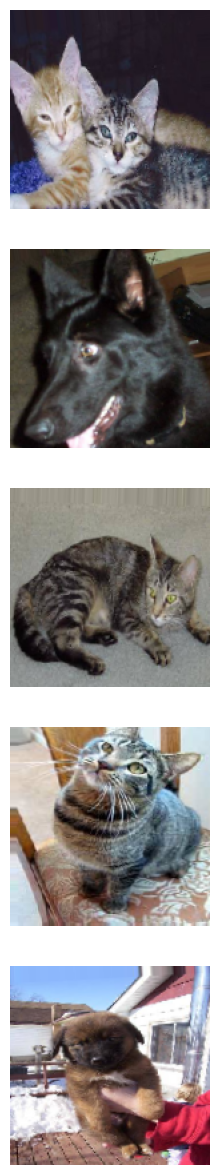

In [15]:
# 4
# Define a function to plot images with optional probabilities
def plotImages(images_arr, probabilities = False):
    # Create subplots for displaying images
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))

    # Iterate through images and axes, if probabilities are provided, display classification information
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

# Display a few sample training images using the defined function
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

## **Data Augmentation**
---
We recreate the image generator for training with random transformations to augment the dataset.

In [8]:
# 5

# Recreate the train_image_generator with random transformations
train_image_generator = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1] range
    rotation_range=15,      # Rotate images by up to 15 degrees
    width_shift_range=0.1,  # Shift the width by a maximum of 10%
    height_shift_range=0.1, # Shift the height by a maximum of 10%
    shear_range=0.1,        # Apply shear transformations
    zoom_range=0.2,         # Apply zoom transformations
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill points outside the input boundaries using the nearest value
)

Found 2000 images belonging to 2 classes.


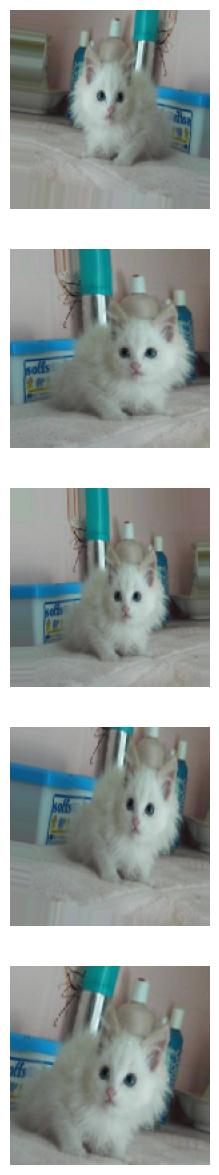

In [9]:
# 6
# Apply data augmentation and display augmented images

# Create a data generator for training with the specified transformations
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,  # Batch size for generating augmented images
                                                     directory=train_dir, # Directory containing training images
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),  # Target image size
                                                     class_mode='binary') # Classification mode for binary classification (cats or dogs)

# Generate augmented images using the defined data generator
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

# Display the augmented images using the previously defined plotImages function
plotImages(augmented_images)

## **Model Architecture**
---
We define a CNN model for image classification.

In [10]:
# 7
# Define the sequential model architecture for image classification
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Convolutional layer with 32 filters and ReLU activation
    MaxPooling2D(2, 2), # MaxPooling layer to downsample the spatial dimensions
    Conv2D(64, (3, 3), activation='relu'), # Additional Convolutional layer with 64 filters and ReLU activation
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'), # One more Convolutional layer with 128 filters and ReLU activation
    MaxPooling2D(2, 2),
    Flatten(), # Flatten the output from the convolutional layers for the fully connected layers
    Dropout(0.25), # Dropout layer to prevent overfitting by randomly dropping 25% of neurons during training
    Dense(128, activation='relu',), # Fully connected layer with 128 units and ReLU activation
    Dense(1, activation='sigmoid')  # Output layer for binary classification using sigmoid activation
])

# Compile the model with specified optimizer, loss function, and evaluation metric
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## **Model Training**
---
We train the model using the training and validation datasets.

In [11]:
# 8
# Train the neural network model using the training and validation datasets
history = model.fit(
    train_data_gen,                            # Training data generator
    steps_per_epoch=total_train // batch_size, # Number of steps per training epoch
    epochs=epochs,                             # Number of training epochs
    validation_data=val_data_gen,              # Validation data generator
    validation_steps=total_val // batch_size   # Number of steps per validation epoch
)

Epoch 1/35
15/15 [==============================] - 27s 964ms/step - loss: 0.8071 - accuracy: 0.4904 - val_loss: 0.6883 - val_accuracy: 0.6116
Epoch 2/35
15/15 [==============================] - 15s 983ms/step - loss: 0.6895 - accuracy: 0.5401 - val_loss: 0.6824 - val_accuracy: 0.6016
Epoch 3/35
15/15 [==============================] - 15s 1s/step - loss: 0.6843 - accuracy: 0.5422 - val_loss: 0.6705 - val_accuracy: 0.5859
Epoch 4/35
15/15 [==============================] - 14s 970ms/step - loss: 0.6673 - accuracy: 0.5978 - val_loss: 0.6374 - val_accuracy: 0.6373
Epoch 5/35
15/15 [==============================] - 15s 983ms/step - loss: 0.6333 - accuracy: 0.6437 - val_loss: 0.6173 - val_accuracy: 0.6797
Epoch 6/35
15/15 [==============================] - 14s 951ms/step - loss: 0.6226 - accuracy: 0.6640 - val_loss: 0.5934 - val_accuracy: 0.6975
Epoch 7/35
15/15 [==============================] - 14s 971ms/step - loss: 0.6012 - accuracy: 0.6757 - val_loss: 0.6356 - val_accuracy: 0.6350
Ep

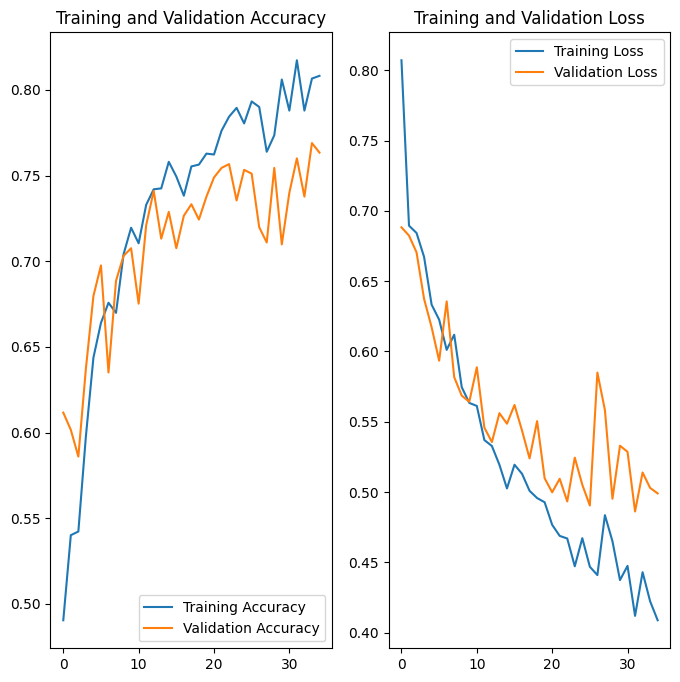

In [12]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Model Evaluation**
---
We predict the labels for the test dataset and evaluate the model's performance.

In [16]:
#10
# Calculate the model's accuracy on the test dataset
probabilities = model.predict(test_data_gen).flatten() # Predict probabilities for the test dataset using the trained model
test_images, _ = next(test_data_gen)                   # Load a batch of test images for visualization
plotImages(test_images, probabilities = probabilities) # Call the 'plotImages' function to display the test images with their predicted probabilities


Output hidden; open in https://colab.research.google.com to view.

In [17]:

# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 82.0% of the images of cats and dogs.
You passed the challenge!
